# Actions are words

The notebook expects pre-created train, val, and test DataFrames stored in the pickle format in the `data/new_datasets` folder. 

## Text manipulation
### Action representation
A action is set of beat elements. A beat element is defined as `<hand><y><x><rotation>` matching pattern `[LR][0-2][0-3][0-9]`. Action of multiple beat elements is created as concatentation in lexicographical with `_` separator. Action is therefore defined as `<hand><y><x><rotation>(_<hand><y><x><rotation>)*`.

Lexicographical ordering ensures all sets of the same beat elements are represented as the same word.

### Load the dataset

In [46]:
from typing import Tuple
import pandas as pd

def load_datasets(storage_folder) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return [pd.read_pickle(storage_folder / f'{phase}_beatmaps.pkl') for phase in
            ['train', 'val', 'test']]

In [47]:
from pathlib import Path

storage_folder = Path('../../data/new_datasets')
train, val, test = load_datasets(storage_folder)

In [48]:
train.head(2)

l_lineLayer  l_lineIndex  l_cutDirection  \
name     difficulty snippet time                                             
100Bills Easy       0       5.71            0            1               1   
                            6.86            0            1               2   

                                  r_lineLayer  r_lineIndex  r_cutDirection  \
name     difficulty snippet time                                             
100Bills Easy       0       5.71            0            1               1   
                            6.86            0            1               2   

                                  word  prev  next  part  ...  \
name     difficulty snippet time                          ...   
100Bills Easy       0       5.71  L011  0.37   0.1 -1.78  ...   
                            6.86  L012  0.10   0.1 -1.75  ...   

                                                                           word_vec  \
name     difficulty snippet time                                                      
100Bills Easy       0       5.71  [0.0273, 0.146, -0.2532, 0.03955, -0.2324, -0....   
                            6.86  [-0.04266, 0.2688, -0.3398, -0.3245, -0.1411, ...   

                                 word_id  prev_l_lineLayer  prev_l_lineIndex  \
name     difficulty snippet time                                               
100Bills Easy       0       5.71       2                 0                 1   
                            6.86       3                 0                 1   

                                  prev_l_cutDirection  prev_r_lineLayer  \
name     difficulty snippet time                                          
100Bills Easy       0       5.71                    1                 0   
                            6.86                    1                 0   

                                  prev_r_lineIndex  prev_r_cutDirection  \
name     difficulty snippet time                                          
100Bills Easy       0       5.71                 1                    1   
                            6.86                 1                    1   

                                                                      prev_word_vec  \
name     difficulty snippet time                                                      
100Bills Easy       0       5.71  [0.0273, 0.146, -0.2532, 0.03955, -0.2324, -0....   
                            6.86  [0.0273, 0.146, -0.2532, 0.03955, -0.2324, -0....   

                                 prev_word_id  
name     difficulty snippet time               
100Bills Easy       0       5.71          2.0  
                            6.86          2.0  

[2 rows x 21 columns]

### Explore the distributions
#### Word frequency distribution

In [49]:
print(f'In the `train` set, there are {len(train.word.value_counts())} unique words.')

In the `train` set, there are 912 unique words.


In [50]:
import numpy as np
zipf = train.word.value_counts().reset_index()
zipf.word = np.log(zipf.word)
zipf.index = np.log(zipf.index + 1)
zipf = zipf.rename(columns={'word': 'Beat Saber'})
zipf['$~x^{-1}$'] = 12 - zipf.index
zipf['$~x^{-1.5}$'] = 12 - zipf.index * 12/8
zipf.head()

,index,Beat Saber,$~x^{-1}$,$~x^{-1.5}$
0.00,L011,10.54,12.00,12.00
0.69,R021,10.36,11.31,10.96
1.10,R031,9.38,10.90,10.35
1.39,R011,9.09,10.61,9.92
1.61,L011_R021,9.01,10.39,9.59


(0.0, 9.0)

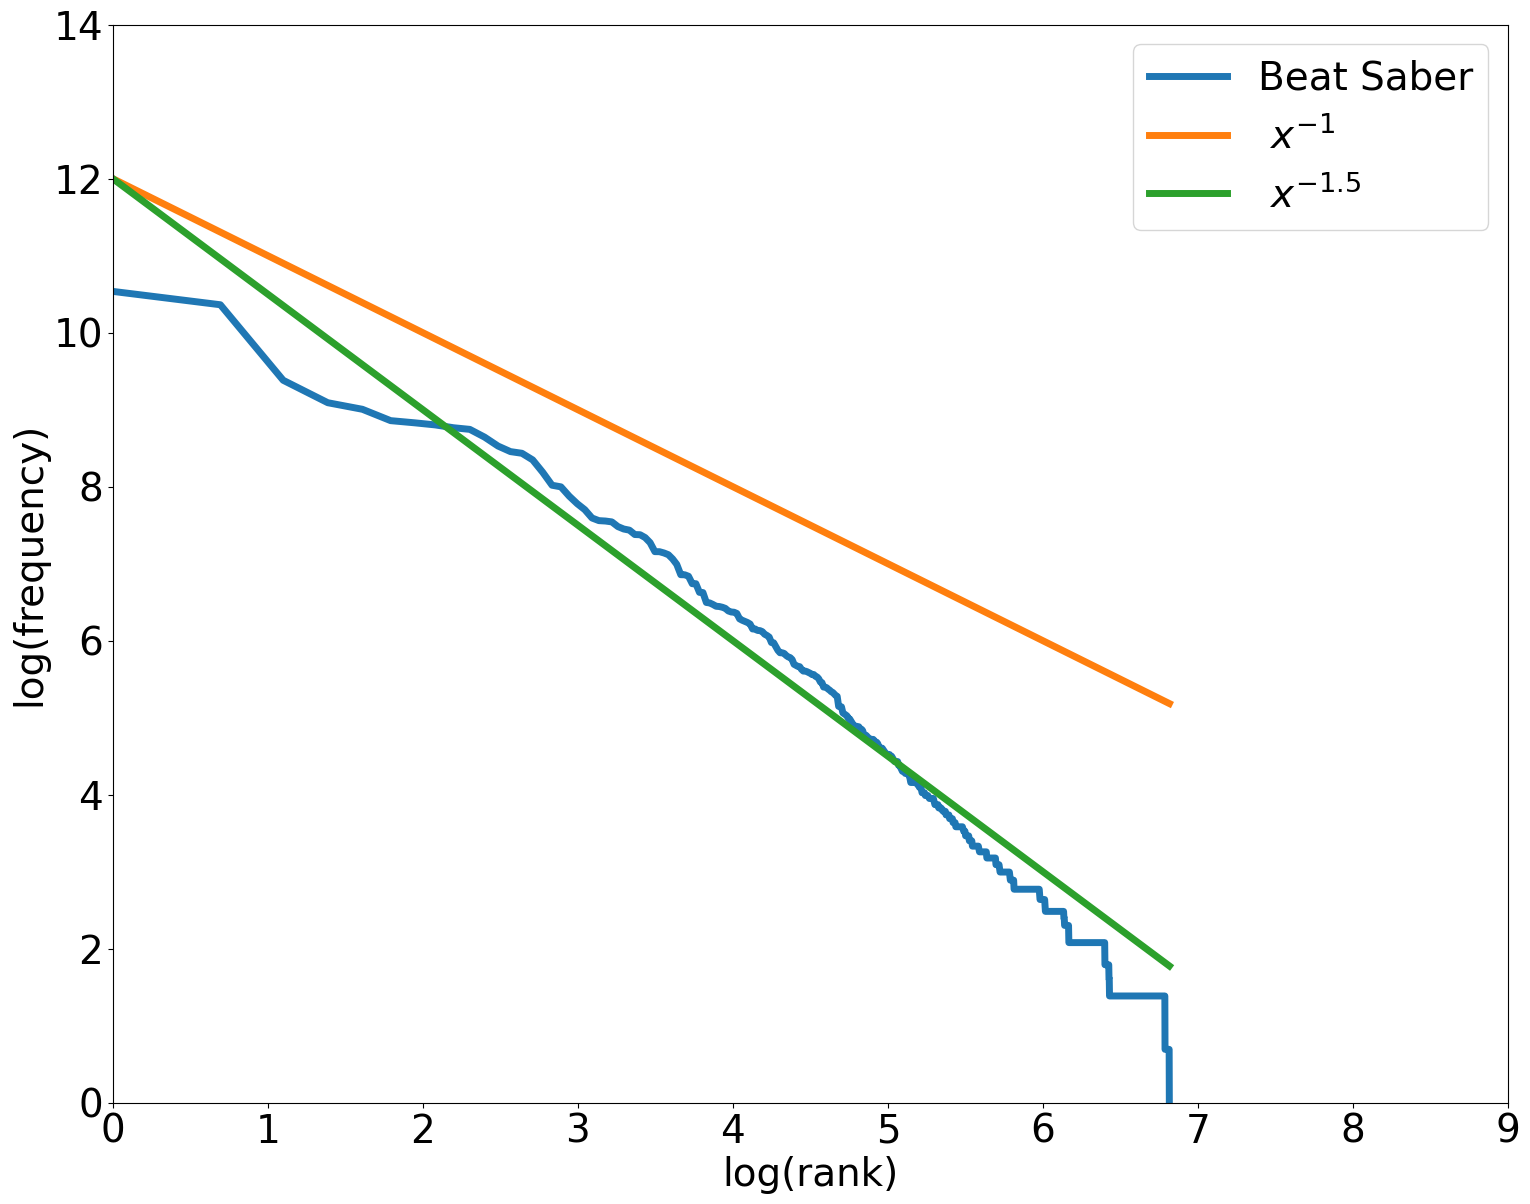

In [51]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})

ax = zipf.plot(figsize=(18, 14), linewidth=5, )
ax.set_ylabel('log(frequency)')
ax.set_xlabel('log(rank)')
ax.set_ylim(0, 14)
ax.set_xlim(0, 9)

The word distribution is pretty much linear in loglog space. It closely follows Zipf's law for word distribution in a language.

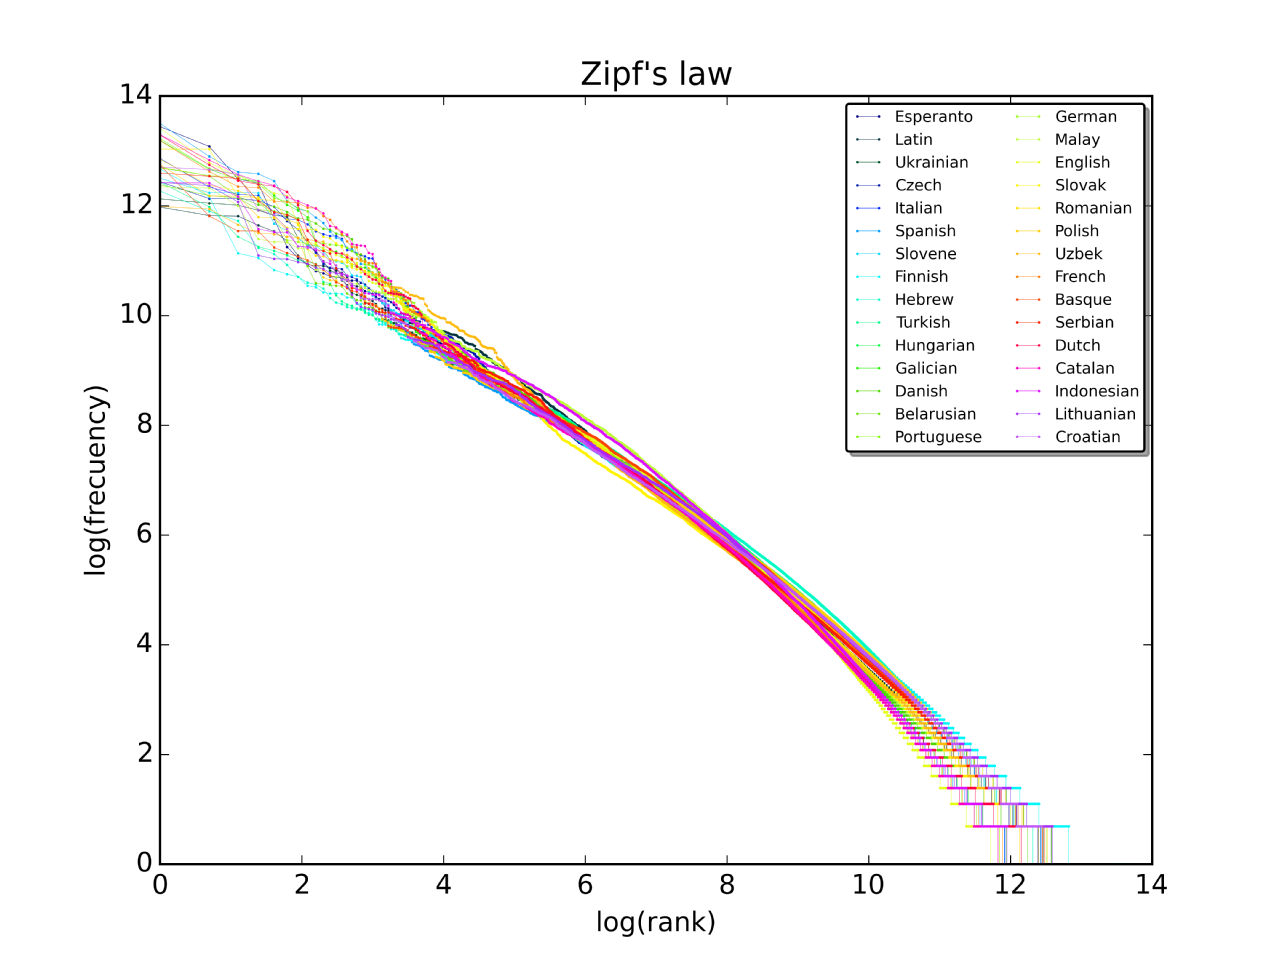 Image source: [[Wikipedia]](https://commons.wikimedia.org/wiki/File:Zipf_30wiki_en_labels.png)

#### Multiple beat elements per beat

<Axes: >

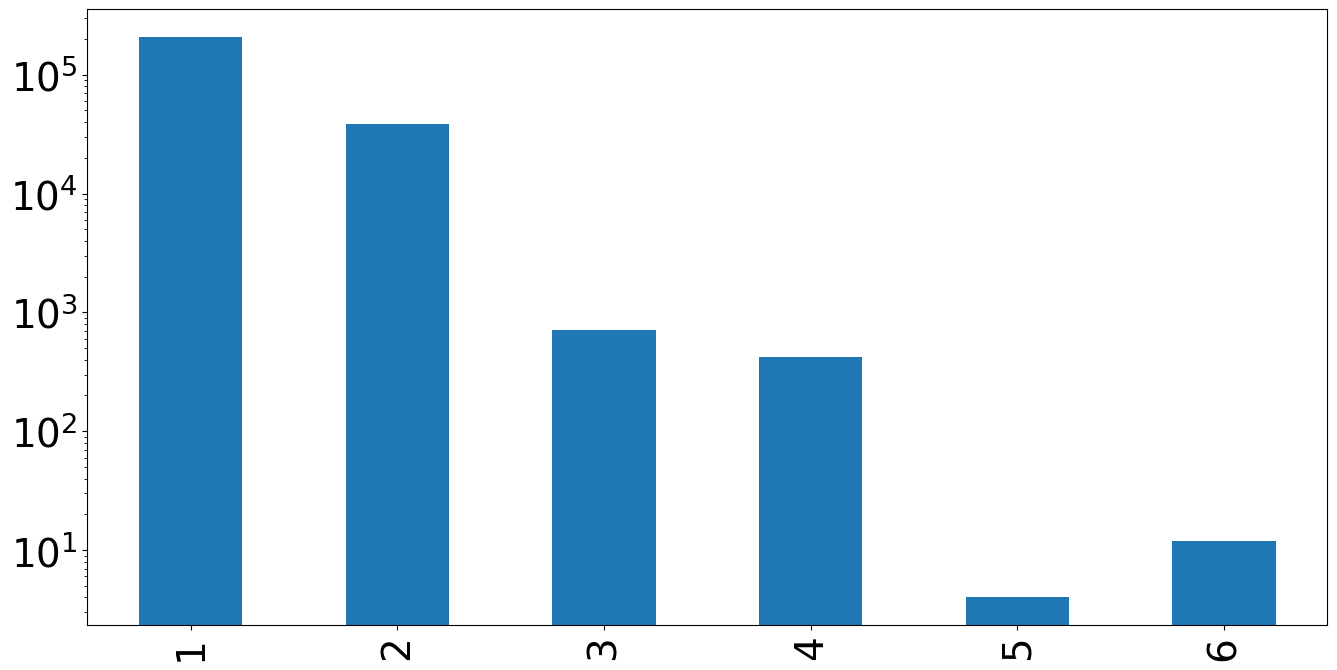

In [52]:
(train.word.str.len() // 5 + 1).value_counts().sort_index().plot.bar(logy=True, figsize=(16, 8))

Number of beat elements per beat also follows logarithmic distribution with dips at odd number of beat elements. This is because of the urge to have symetric moves if slicing more than one beat element per beat.

### Train, val, test overlap

In [53]:
len(set(val.word.unique()) - set(train.word.unique()))

18

In [54]:
len(set(test.word.unique()) - set(train.word.unique()))

55

## Generate sentences
Generate sentences from the `train` set, one song per line. Making it easy to train and evaluate word vectors with `gensim`.

In [55]:
def create_sentence(x):
    x.name = 'word'
    x = x.reset_index('time')
    x = x.drop_duplicates('time')
    x = x.word.str.cat(sep=' ')
    return x

def word_df2text(df: pd.DataFrame):
    return df.droplevel(2).word.groupby(['name', 'difficulty']).apply(create_sentence).str.cat(sep='\n')

train_text = word_df2text(train)
val_text = word_df2text(val)

In [56]:
len(train_text), len(train.word.str.cat(sep=' ')) # should be ~half the size

(704689, 1431314)

In [57]:
with open(storage_folder / 'train_text.cor', 'w') as wf:
    wf.write(train_text)
with open(storage_folder / 'val_text.cor', 'w') as wf:
    wf.write(val_text)

## Create test analogies
Similarly as in Test set developed by Mikolov et al.[1], where the word vectors are evaluated on automatically generated analogies:
```
: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany

: currency
Algeria dinar Angola kwanza
Algeria dinar Argentina peso
Algeria dinar Armenia dram
Algeria dinar Brazil real
```
- For example `Athens Greece Baghdad Iraq` from `capital-common-countries` analogy means:
    - Athens to Greece are like Baghdad to Iraq

We would like to create analogies in action vector space using translation, rotation and hand swaping as follows:
```
: single-hand-translation
L030 L000 L130 L100
L030 L000 L230 L200
L130 L100 L030 L000
L130 L100 L230 L200

: single-hand-rotation
L008 L000 L018 L010
L008 L000 L028 L020
L008 L000 L038 L030
L008 L000 L108 L100

: single-hand-hand-swap
L000 R000 L121 R121
L000 R000 L122 R122
L000 R000 L123 R123
L000 R000 L124 R124

: single-hand-doublebeat
L032 L032_L002 L132 L132_L102
L032 L032_L002 L232 L232_L202
L132 L132_L102 L032 L032_L002
L132 L132_L102 L232 L232_L202
...
```

#### Reasoning
For example `L030 L000 L130 L100` from `single-hand-translation` analogy means:
- The relation between coordinates `(3, 0)` and `(0, 0)` (while leaving the same hand and rotation) should be the same as the relation between coordinates `(3, 1)` and `(0, 1)`
- The coordinate difference is independent of the absolute coordinate

For example `L000 R000 L121 R121` from `single-hand-hand-rotation` analogy means:
- The relation between left and right hand at coordinate `(0, 0)` and rotation `0` should be the same as the relation between left and right hand at the coordinate `(2, 1)` and rotation `1`
- The hand relation is independent of position or rotation

For example `L008 L000 L018 L010` from `single-hand-rotation` analogy means:
- The relation between rotation `8` and rotation `0` in left hand at coordinate `(0, 0)` should be the same as the relation between rotation `8` and rotation `0` in left hand at coordinate `(1, 0)`
- The rotation change is independent of position

For example `L032 L032_L002 L132 L132_L102` from `single-hand-doublebeat` analogy means:
- The relation between a single beat element action of left hand at coordinate `(3, 0)` and rotation `2` and double beat element action with additional beat element at coordinate `(0, 0)` and rotation `2` should be the same as the relation between a single beat element action of left hand at coordinate `(3, 1)` and rotation `2` and double beat element action with additional beat element at coordinate `(0, 1)` and rotation `2`
- The coordinate difference between single and double actions is independent of the absolute coordinate

#### Remarks
- The analogy dataset contains a both-hand versions of `single-hand-translation` and `single-hand-hand-rotation` called `double-hand-translation` and `double-hand-hand-rotation`.
- Where reasonable, the analogy sections are split into "only x change", "only y change", "both x and y change" for better performance understanding

[1] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. In Proceedings of International Conference on Learning Representations (ICLR).

#### Word creation

In [58]:
from typing import Tuple, Any

def subword_tuple2string(tuple: Tuple[Any]):
    return ''.join([str(x) for x in tuple])


def word_tuple2string(tuple: Tuple[Any]):
    for subword_id in range(0, len(tuple), 4):
        if not (tuple[subword_id + 0] in 'LR'
                and 0 <= tuple[subword_id + 1] < 3
                and 0 <= tuple[subword_id + 2] < 4
                and 0 <= tuple[subword_id + 3] < 9):
            return None
    return '_'.join(
        [subword_tuple2string(tuple[subword_id:subword_id + 4]) for subword_id in range(0, len(tuple), 4)])

#### Analogies helper functions

In [59]:
from itertools import product

def add_valid_translations_one_hand(lines, translation):
    def create_word_tuples(hand, position, rotation, translation):
        tuple_from = hand, *position, rotation
        tuple_to = [a + b for a, b in zip(tuple_from, translation)]
        return tuple_from, tuple_to

    add_valid_translation(lines, translation, create_word_tuples)
    return lines


def add_valid_translations_one_hand_doublebeat(lines, translation, rotation):
    def create_word_tuples_multiplication(hand, position, rotation, translation):
        tuple_from = hand, *position, rotation
        tuple_to = *tuple_from, *[a + b for a, b in zip(tuple_from, translation)]
        return tuple_from, tuple_to

    def create_word_tuples_demultiplication(hand, position, rotation, translation):
        return create_word_tuples_multiplication(hand, position, rotation, translation)[::-1]

    for hand in 'LR':
        add_valid_translation_only_positions(lines, hand, rotation, translation, create_word_tuples_multiplication)
        add_valid_translation_only_positions(lines, hand, rotation, translation, create_word_tuples_demultiplication)
    return lines


def add_valid_translations_two_hand(lines, translation, hand_translation):
    def create_word_tuples(hand, position, rotation, translation):
        left_from = hand, *position, rotation
        right_from = 'R', *position, rotation
        tuple_from = *left_from, *[a + b for a, b in zip(right_from, hand_translation)]
        tuple_to = [a + b for a, b in zip(tuple_from, translation * 2)]
        return tuple_from, tuple_to

    for hand, rotation in product('L', range(-8, 9)):
        add_valid_translation_only_positions(lines, hand, rotation, translation, create_word_tuples)
    return lines


def add_valid_translations_one_hand_demultiply(lines, translation, rotation):
    def create_word_tuples(hand, position, rotation, translation):
        tuple_to = hand, *position, rotation
        tuple_from = *tuple_to, *[a + b for a, b in zip(tuple_to, translation)]
        return tuple_from, tuple_to

    for hand in 'LR':
        add_valid_translation_only_positions(lines, hand, rotation, translation, create_word_tuples)
    return lines


def add_valid_translation(lines, translation, create_word_tuples):
    for hand, rotation in product('LR', range(9)):
        add_valid_translation_only_positions(lines, hand, rotation, translation, create_word_tuples)


def add_valid_translation_only_positions(lines, hand, rotation, translation, create_word_tuples):
    for example_position in product(range(3), range(4)):
        example_from, example_to = create_word_tuples(hand, example_position, rotation, translation)

        for question_position in product(range(3), range(4)):
            question_from, question_to = create_word_tuples(hand, question_position, rotation, translation)
            add_valid_analogy(lines, example_from, example_to, question_from, question_to)


def add_valid_analogy(lines, example_from, example_to, question_from, question_to):
    """Add analogy to `lines` if all words are valid"""
    if example_from != question_from:  # skip identical analogies
        analogy = [word_tuple2string(x) for x in [example_from, example_to, question_from, question_to]]
        if None not in analogy:
            lines.append(' '.join(analogy))

#### Analogy creation

In [60]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


def create_analogies(path: Path):
    """
    Shape of a beat element is [hand][y][x][rotation]. A word is of shape [beat-element][_beat-element]*.
    """
    lines = []

    def new_section(name: str):
        logging.info(f'Generating analogies for section {name}')
        lines.append(f': {name}')

    new_section('single-hand-translation-x')
    for dx in range(-3, 4):
        if dx == 0:  # remove identity translation
            continue
        translation = '', 0, dx, 0
        add_valid_translations_one_hand(lines, translation)

    new_section('single-hand-translation-y')
    for dy in range(-2, 3):
        if dy == 0:  # remove identity translation
            continue
        translation = '', dy, 0, 0
        add_valid_translations_one_hand(lines, translation)

    new_section('single-hand-translation-other')
    for dydx in product(range(-2, 3), range(-3, 4)):
        if 0 in dydx:  # previously used translations
            continue
        translation = '', *dydx, 0

        add_valid_translations_one_hand(lines, translation)

    new_section('single-hand-rotation')
    for rotation_change in range(-8, 9):
        if rotation_change == 0:  # remove identity rotation change
            continue
        translation = '', 0, 0, rotation_change
        add_valid_translations_one_hand(lines, translation)

    new_section('single-hand-hand-swap')
    for hand_id in range(2):
        hand_from = 'LR'[hand_id]
        hand_to = 'RL'[hand_id]

        for example_position in product(range(3), range(4), range(9)):
            example_from = hand_from, *example_position
            example_to = hand_to, *example_position
            for qustion_position in product(range(3), range(4), range(9)):
                question_from = hand_from, *qustion_position
                question_to = hand_to, *qustion_position
                add_valid_analogy(lines, example_from, example_to, question_from, question_to)

    new_section('single-hand-doublebeat-y')
    for dy, rotation in product(range(-2, 3), [0, 1]):
        if dy == 0:  # remove identity multiplication
            continue
        translation = '', dy, 0, 0
        add_valid_translations_one_hand_doublebeat(lines, translation, rotation)

    new_section('single-hand-doublebeat-x')
    for dx, rotation in product(range(-3, 4), [2, 3]):
        if dx == 0:  # remove identity multiplication
            continue
        translation = '', 0, dx, 0
        add_valid_translations_one_hand_doublebeat(lines, translation, rotation)

    new_section('single-hand-doublebeat-other')
    for dx, dy, rotation in product(range(-2, 3), range(-3, 4), range(9)):
        if 0 in dydx:  # previously used multiplication
            continue
        translation = '', dy, dx, 0
        add_valid_translations_one_hand_doublebeat(lines, translation, rotation)

    new_section('double-hand-translation-x')
    for dx, right_dx, right_drotation in product(range(-3, 4), range(-3, 4), range(-8, 9)):
        if dx == 0 or right_dx == 0:  # remove identity translation
            continue
        translation = '', 0, dx, 0
        right_translation = '', 0, right_dx, right_drotation
        add_valid_translations_two_hand(lines, translation, right_translation)

    new_section('double-hand-translation-y')
    for dy, right_dy, right_drotation in product(range(-2, 3), range(-2, 3), range(-8, 9)):
        if dy == 0 or right_dy == 0:  # remove identity translation
            continue
        translation = '', dy, 0, 0
        right_translation = '', right_dy, 0, right_drotation
        add_valid_translations_two_hand(lines, translation, right_translation)

    # Generates mostly unused beat combinations, yet doubles the testing time
    # new_section('double-hand-translation-other')
    # for dy, dx, right_dy, right_dx, right_drotation in product(range(-2, 3), range(-3, 4),
    #                                                            range(-2, 3), range(-3, 4),
    #                                                            range(-8, 9)):
    #     if 0 in (dy, dx, right_dy, right_dx):  # remove previously used
    #         continue
    #     translation = '', dy, dx, 0
    #     right_translation = '', right_dy, right_dx, right_drotation
    #     add_valid_translations_two_hand(lines, translation, right_translation)

    new_section('double-hand-rotation-x')
    for rotation, right_dx, right_drotation in product(range(-8, 9), range(-3, 4), range(-8, 9)):
        if right_dx == 0:  # remove identity translation
            continue
        translation = '', 0, 0, rotation
        right_translation = '', 0, right_dx, right_drotation
        add_valid_translations_two_hand(lines, translation, right_translation)

    new_section('double-hand-rotation-y')
    for rotation, right_dy, right_drotation in product(range(-8, 9), range(-2, 3), range(-8, 9)):
        if right_dy == 0:  # remove identity translation
            continue
        translation = '', 0, 0, rotation
        right_translation = '', right_dy, 0, right_drotation
        add_valid_translations_two_hand(lines, translation, right_translation)

    # Generates mostly unused beat combinations, yet doubles the testing time
    # new_section('double-hand-rotation-other')
    # for rotation, right_dy, right_dx, right_drotation in product(range(-8, 9),
    #                                                              range(-2, 3), range(-3, 4),
    #                                                              range(-8, 9)):
    #     if 0 in (right_dy, right_dx):  # remove previously used
    #         continue
    #     translation = '', 0, 0, rotation
    #     right_translation = '', right_dy, right_dx, right_drotation
    #     add_valid_translations_two_hand(lines, translation, right_translation)

    with open(path, 'w') as wf:
        wf.write('\n'.join(lines) + '\n')

### Perform and save

In [61]:
create_analogies(storage_folder / 'beat_analogies.txt')

2024-09-23 16:30:01,046 : INFO : Generating analogies for section single-hand-translation-x
2024-09-23 16:30:01,116 : INFO : Generating analogies for section single-hand-translation-y
2024-09-23 16:30:01,165 : INFO : Generating analogies for section single-hand-translation-other
2024-09-23 16:30:01,442 : INFO : Generating analogies for section single-hand-rotation
2024-09-23 16:30:01,625 : INFO : Generating analogies for section single-hand-hand-swap
2024-09-23 16:30:01,741 : INFO : Generating analogies for section single-hand-doublebeat-y
2024-09-23 16:30:01,766 : INFO : Generating analogies for section single-hand-doublebeat-x
2024-09-23 16:30:01,803 : INFO : Generating analogies for section single-hand-doublebeat-other
2024-09-23 16:30:02,672 : INFO : Generating analogies for section double-hand-translation-x
2024-09-23 16:30:07,745 : INFO : Generating analogies for section double-hand-translation-y
2024-09-23 16:30:09,982 : INFO : Generating analogies for section double-hand-rotati

## Train word embeddings

In [62]:
import gensim

def create_train_model(corpus_file, model_type: str='fasttext', **kwargs):
    kwargs = {key: int(val) for key, val in kwargs.items()}
    kwargs['size'] = 2 ** kwargs['size']
    workers = 12
    # change `workers` to suit our machine thread count
    if model_type.lower() == 'fasttext':
        model = gensim.models.FastText(corpus_file=str(corpus_file), **kwargs, workers=workers)
    else:
        model = gensim.models.Word2Vec(corpus_file=str(corpus_file), **kwargs, workers=workers)
    
    return model

def create_eval_function(corpus_file: Path, model_type: str):
    def eval_model(**kwargs):
        model = create_train_model(corpus_file, model_type, **kwargs)

        res = model.wv.evaluate_word_analogies(storage_folder / 'beat_analogies.txt')

        return res[0]
    
    return eval_model

In [63]:
from bayes_opt import BayesianOptimization
root = logging.getLogger()
root.setLevel(logging.ERROR)

### Evaluate random projection

In [64]:
from scipy import stats

accuracies = []
for size, _ in product(range(4, 9), range(2)):
    acc = create_eval_function(storage_folder / 'train_text.cor', 'word2vec')(iter=0, size=size)
    accuracies.append(acc)

accuracy = {}
acc_desc = stats.describe(accuracies)
accuracy['random'] = acc_desc.minmax[1]  # get maximum
print(f'{acc_desc.mean} +-{2 * acc_desc.variance}')

2024-09-23 16:30:34,986 : INFO : collecting all words and their counts
2024-09-23 16:30:34,989 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:30:35,002 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:30:35,003 : INFO : Loading a fresh vocabulary
2024-09-23 16:30:35,004 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:30:35,004 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:30:35,005 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:30:35,005 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:30:35,005 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:30:35,006 : INFO : estimated required memory for 475 words and 16 dimensions: 298300 bytes
2024-09-23 16:30:35,007 : INFO : resetting layer weights
20

0.002475539313921961 +-1.6088897153826385e-06


### Train Word2Vec

In [65]:
bool_ = (0.1, 1.9)
pbounds = {
    'size': (4, 8),         # log int
    'window': (1, 7),       # int
    'iter': (1.1, 20),      # int  : Number of iterations (epochs) over the corpus.
    'sg': bool_,            # bool : skip-gram if `sg=1`, otherwise CBOW.
    'hs': bool_,            # bool : If 1, hierarchical softmax will be used for model training.
                            #        If set to 0, and `negative` is non-zero, negative sampling will be used.
    'cbow_mean': bool_,     # bool : If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.
}

word2vec_optimizer = BayesianOptimization(
    f=create_eval_function(storage_folder / 'train_text.cor', 'word2vec'),
    pbounds=pbounds,
    random_state=1,
)

word2vec_optimizer.maximize(
    init_points=2,
    n_iter=3,
)

2024-09-23 16:30:59,419 : INFO : collecting all words and their counts
2024-09-23 16:30:59,421 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:30:59,443 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:30:59,443 : INFO : Loading a fresh vocabulary
2024-09-23 16:30:59,445 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:30:59,446 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:30:59,447 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:30:59,448 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:30:59,448 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:30:59,449 : INFO : constructing a huffman tree from 475 words
2024-09-23 16:30:59,457 : INFO : built huffman tree with maximum node depth 15
2024-09-2

|   iter    |  target   | cbow_mean |    hs     |   iter    |    sg     |   size    |  window   |
-------------------------------------------------------------------------------------------------


2024-09-23 16:30:59,533 : INFO : training model with 12 workers on 475 vocabulary and 16 features, using sg=0 hs=1 sample=0.001 negative=5 window=1
2024-09-23 16:30:59,564 : INFO : worker thread finished; awaiting finish of 11 more threads
2024-09-23 16:30:59,570 : INFO : worker thread finished; awaiting finish of 10 more threads
2024-09-23 16:30:59,572 : INFO : worker thread finished; awaiting finish of 9 more threads
2024-09-23 16:30:59,573 : INFO : worker thread finished; awaiting finish of 8 more threads
2024-09-23 16:30:59,573 : INFO : worker thread finished; awaiting finish of 7 more threads
2024-09-23 16:30:59,573 : INFO : worker thread finished; awaiting finish of 6 more threads
2024-09-23 16:30:59,574 : INFO : worker thread finished; awaiting finish of 5 more threads
2024-09-23 16:30:59,574 : INFO : worker thread finished; awaiting finish of 4 more threads
2024-09-23 16:30:59,575 : INFO : worker thread finished; awaiting finish of 3 more threads
2024-09-23 16:30:59,575 : INFO 

| 1         | 0.03089   | 0.8506    | 1.397     | 1.102     | 0.6442    | 4.587     | 1.554     |


2024-09-23 16:31:00,556 : INFO : worker thread finished; awaiting finish of 11 more threads
2024-09-23 16:31:00,559 : INFO : worker thread finished; awaiting finish of 10 more threads
2024-09-23 16:31:00,559 : INFO : worker thread finished; awaiting finish of 9 more threads
2024-09-23 16:31:00,560 : INFO : worker thread finished; awaiting finish of 8 more threads
2024-09-23 16:31:00,561 : INFO : worker thread finished; awaiting finish of 7 more threads
2024-09-23 16:31:00,561 : INFO : worker thread finished; awaiting finish of 6 more threads
2024-09-23 16:31:00,561 : INFO : worker thread finished; awaiting finish of 5 more threads
2024-09-23 16:31:00,564 : INFO : worker thread finished; awaiting finish of 4 more threads
2024-09-23 16:31:00,564 : INFO : worker thread finished; awaiting finish of 3 more threads
2024-09-23 16:31:00,565 : INFO : worker thread finished; awaiting finish of 2 more threads
2024-09-23 16:31:00,565 : INFO : worker thread finished; awaiting finish of 1 more threa

| 2         | 0.03861   | 0.4353    | 0.722     | 8.599     | 1.07      | 5.677     | 5.111     |


2024-09-23 16:31:03,652 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:03,669 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:03,671 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:03,671 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:03,673 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:03,674 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:03,675 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:03,676 : INFO : estimated required memory for 475 words and 32 dimensions: 359100 bytes
2024-09-23 16:31:03,677 : INFO : resetting layer weights
2024-09-23 16:31:03,753 : INFO : training model with 12 workers on 475 vocabulary and 32 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2024-09-23 16:31:03,782 

| 3         | 0.04368   | 0.8709    | 0.3923    | 8.54      | 0.5979    | 5.777     | 5.031     |


2024-09-23 16:31:06,688 : INFO : collecting all words and their counts
2024-09-23 16:31:06,691 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:06,708 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:06,709 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:06,711 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:06,711 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:06,713 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:06,713 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:06,714 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:06,715 : INFO : estimated required memory for 475 words and 32 dimensions: 359100 bytes
2024-09-23 16:31:06,715 : INFO : resetting layer weights
20

| 4         | 0.05169   | 1.386     | 0.1       | 8.47      | 0.1       | 5.896     | 4.935     |


2024-09-23 16:31:10,067 : INFO : collecting all words and their counts
2024-09-23 16:31:10,068 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:10,083 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:10,083 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:10,084 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:10,084 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:10,085 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:10,085 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:10,086 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:10,086 : INFO : estimated required memory for 475 words and 64 dimensions: 480700 bytes
2024-09-23 16:31:10,087 : INFO : resetting layer weights
20

| 5         | 0.05157   | 1.9       | 0.1       | 7.966     | 0.1       | 6.76      | 4.243     |


### Train FastText

In [66]:
bool_ = (0.1, 1.9)
pbounds = {
    'size': (4, 8),         # log int
    'window': (1, 7),       # int
    'iter': (1.1, 20),      # int  : Number of iterations (epochs) over the corpus.
    'sg': bool_,            # bool : skip-gram if `sg=1`, otherwise CBOW.
    'hs': bool_,            # bool : If 1, hierarchical softmax will be used for model training.
                            #        If set to 0, and `negative` is non-zero, negative sampling will be used.
    # 'sample': (0, 1e-5),   # float: The threshold for configuring which higher-frequency words are randomly downsampled,
    # 'negative': (0, 20),   # int  : If > 0, negative sampling will be used, the int for negative specifies how many "noise words"
    'cbow_mean': bool_,     # bool : If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.
    'min_n': (2, 5),        # int  : Minimum length of char n-grams to be used for training word representations.
    'max_n': (3, 9),        # int  : Max length of char ngrams to be used for training word representations. Set `max_n` to be lesser than `min_n` to avoid char ngrams being used.
    'word_ngrams': bool_,   # bool : If 1, uses enriches word vectors with subword(n-grams) information.
                            #        If 0, this is equivalent to :class:`~gensim.models.word2vec.Word2Vec`.
}

fasttext_optimizer = BayesianOptimization(
    f=create_eval_function(storage_folder / 'train_text.cor', 'fasttext'),
    pbounds=pbounds,
    random_state=1,
)

fasttext_optimizer.maximize(
    init_points=2,
    n_iter=3,
)

2024-09-23 16:31:13,081 : INFO : resetting layer weights


|   iter    |  target   | cbow_mean |    hs     |   iter    |   max_n   |   min_n   |    sg     |   size    |  window   | word_n... |
-------------------------------------------------------------------------------------------------------------------------------------


2024-09-23 16:31:13,500 : INFO : collecting all words and their counts
2024-09-23 16:31:13,501 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:13,513 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:13,513 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:13,514 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:13,514 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:13,515 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:13,515 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:13,516 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:13,516 : INFO : constructing a huffman tree from 475 words
2024-09-23 16:31:13,519 : INFO : built huffman tree with maximum node depth 15
2024-09-2

| 1         | 0.3109    | 0.8506    | 1.397     | 1.102     | 4.814     | 2.44      | 0.2662    | 4.745     | 3.073     | 0.8142    |


2024-09-23 16:31:16,126 : INFO : collecting all words and their counts
2024-09-23 16:31:16,126 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:16,138 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:16,139 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:16,140 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:16,140 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:16,141 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:16,141 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:16,141 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:16,142 : INFO : estimated required memory for 475 words, 380 buckets and 64 dimensions: 626900 bytes
2024-09-23 16:31:16,143 : INFO : resetting lay

| 2         | 0.1832    | 1.07      | 0.8546    | 14.05     | 4.227     | 4.634     | 0.1493    | 6.682     | 3.504     | 1.106     |


2024-09-23 16:31:20,611 : INFO : collecting all words and their counts
2024-09-23 16:31:20,612 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:20,624 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:20,624 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:20,625 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:20,625 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:20,626 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:20,626 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:20,626 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:20,627 : INFO : constructing a huffman tree from 475 words
2024-09-23 16:31:20,630 : INFO : built huffman tree with maximum node depth 15
2024-09-2

| 3         | 0.283     | 1.261     | 1.807     | 1.512     | 5.224     | 2.85      | 0.6763    | 5.155     | 3.483     | 1.224     |


2024-09-23 16:31:24,407 : INFO : resetting layer weights
2024-09-23 16:31:24,735 : INFO : collecting all words and their counts
2024-09-23 16:31:24,736 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:24,748 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:24,749 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:24,749 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:24,750 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:24,750 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:24,751 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:24,751 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:24,751 : INFO : estimated required memory for 475 words, 2000000 buckets and 16 dimensions

| 4         | 0.4264    | 0.1       | 0.1       | 1.1       | 3.0       | 2.0       | 0.1       | 4.0       | 1.0       | 0.1       |


2024-09-23 16:31:26,125 : INFO : resetting layer weights
2024-09-23 16:31:26,490 : INFO : collecting all words and their counts
2024-09-23 16:31:26,491 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:26,504 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:26,505 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:26,506 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:26,506 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:26,507 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:26,507 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:26,508 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:26,509 : INFO : estimated required memory for 475 words, 2000000 buckets and 16 dimensions

| 5         | 0.5149    | 0.1       | 0.1       | 5.011     | 3.0       | 2.0       | 0.1       | 4.0       | 1.0       | 0.1       |


### Select the best hyper params

In [67]:
rdf = pd.DataFrame(word2vec_optimizer.res)
accuracy['search word2vec'], wordvec_params = rdf.loc[rdf['target'].idxmax()].to_list()

rdf = pd.DataFrame(fasttext_optimizer.res)
accuracy['search fasttext'], fasttext_params = rdf.loc[rdf['target'].idxmax()].to_list()

wordvec_params, fasttext_params

({'cbow_mean': 1.3860189293213159,
  'hs': 0.1,
  'iter': 8.469645656525838,
  'sg': 0.1,
  'size': 5.895763463174126,
  'window': 4.935176579163876},
 {'cbow_mean': 0.1,
  'hs': 0.1,
  'iter': 5.010816908170368,
  'max_n': 3.0,
  'min_n': 2.0,
  'sg': 0.1,
  'size': 4.0,
  'window': 1.0,
  'word_ngrams': 0.1})

#### Or set really good ones if there was not time for search

In [68]:
word2vec_params = {
    'cbow_mean': True,
    'hs': False,
    'iter': 3,
    'sg': False,
    'size': 5,
    'window': 1,
}

fasttext_params = {
    'cbow_mean': True,
    'hs': False, 
    'iter': 3,
    'max_n': 3,
    'min_n': 2,
    'sg': False,
    'size': 9,
    'window': 1,
    'word_ngrams': True,
}   # ngrams

fasttext_params = {
    'cbow_mean': True,
    'hs': False,
    'iter': 3,
    'max_n': 3,
    'min_n': 2,
    'sg': False,
    'size': 8,
    'window': 1,
    'word_ngrams': False
}   # without ngrams


model = create_train_model(storage_folder / 'train_text.cor', 'word2vec', **word2vec_params)
accuracy['good word2vec'] = model.wv.evaluate_word_analogies(storage_folder / 'beat_analogies.txt')[0]

model = create_train_model(storage_folder / 'train_text.cor', 'fasttext', **fasttext_params)
accuracy['good fasttext'] = model.wv.evaluate_word_analogies(storage_folder / 'beat_analogies.txt')[0]

2024-09-23 16:31:27,789 : INFO : collecting all words and their counts
2024-09-23 16:31:27,790 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:27,802 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:27,802 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:27,803 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:27,803 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:27,804 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:27,804 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:27,805 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:27,805 : INFO : estimated required memory for 475 words and 32 dimensions: 359100 bytes
2024-09-23 16:31:27,805 : INFO : resetting layer weights
20

#### Performance on train set

In [69]:
pd.DataFrame(data=accuracy.values(), index=accuracy.keys(), columns=['best top1 accuracy [%]'])\
    .sort_values('best top1 accuracy [%]') * 100

,best top1 accuracy [%]
random,0.34
good word2vec,3.70
search word2vec,5.17
good fasttext,47.80
search fasttext,51.49


### Remarks
Analogy evaluation is done on top1 accuracy. Word2vec embeddings achieve significantly better performance than random (~2000 embedded words => 1/2000 = 0.05 %, empirically shown above as 0.052743), yet are over 5× outperformed by FastText. This can be explained by the sub-word insight the FastText model gets as the semantic information is directly represented by the syntax of a word. This is especially prominent in the multi beat element actions which are composed of the individual beat element actions.

### Try performance on `val` set
`val` set was not used for the creation of beat vectors in the hyper parameter search, therefore we can use it for the evaluation.

`val` set may achieve higher accuracy on the analogy task. Any words with less than 5 occurences are cut. This leaves less hard analogy pairs in the analogy evaluation.

In [70]:
model = create_train_model(storage_folder / 'train_text.cor', 'fasttext', **fasttext_params)
train_accuracy = model.wv.evaluate_word_analogies(storage_folder / 'beat_analogies.txt')[0]
root.setLevel(logging.INFO)

val_accuracy = create_eval_function(storage_folder / 'val_text.cor', 'fasttext')(**fasttext_params)
print(f'New model achieved {train_accuracy * 100:7.4} % accuracy on the train data.')
print(f'New model achieved {val_accuracy * 100:7.4} % accuracy on the validation data.')

2024-09-23 16:31:42,448 : INFO : resetting layer weights
2024-09-23 16:31:49,579 : INFO : collecting all words and their counts
2024-09-23 16:31:49,580 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:31:49,592 : INFO : collected 912 word types from a corpus of 120006 raw words and 220 sentences
2024-09-23 16:31:49,592 : INFO : Loading a fresh vocabulary
2024-09-23 16:31:49,593 : INFO : effective_min_count=5 retains 475 unique words (52% of original 912, drops 437)
2024-09-23 16:31:49,593 : INFO : effective_min_count=5 leaves 118875 word corpus (99% of original 120006, drops 1131)
2024-09-23 16:31:49,594 : INFO : deleting the raw counts dictionary of 912 items
2024-09-23 16:31:49,594 : INFO : sample=0.001 downsamples 50 most-common words
2024-09-23 16:31:49,594 : INFO : downsampling leaves estimated 44003 word corpus (37.0% of prior 118875)
2024-09-23 16:31:49,595 : INFO : estimated required memory for 475 words, 2000000 buckets and 256 dimension

New model achieved   46.69 % accuracy on the train data.
New model achieved   47.04 % accuracy on the validation data.


### Try performance by hand

In [71]:
from scipy.spatial import distance
distance.cosine(model.wv['L000'], model.wv['R125_R217'])

1.066569098708537

In [72]:
distance.cosine(model.wv['L000'], model.wv['L001'])

0.04089452674445804

### Save the best model

In [73]:
model.wv.save_word2vec_format(str(storage_folder / 'word2vec.model'), binary=False)

2024-09-23 16:32:06,430 : INFO : storing 475x256 projection weights into ../../data/new_datasets/word2vec.model


In [74]:
model.wv.save(str(storage_folder / 'fasttext.model'))

2024-09-23 16:32:06,491 : INFO : saving FastTextKeyedVectors object under ../../data/new_datasets/fasttext.model, separately None
2024-09-23 16:32:06,491 : INFO : storing np array 'vectors_ngrams' to ../../data/new_datasets/fasttext.model.vectors_ngrams.npy
2024-09-23 16:32:06,858 : INFO : not storing attribute vectors_ngrams_norm
2024-09-23 16:32:06,859 : INFO : not storing attribute vectors_norm
2024-09-23 16:32:06,859 : INFO : not storing attribute vectors_vocab_norm
2024-09-23 16:32:06,859 : INFO : not storing attribute buckets_word
2024-09-23 16:32:06,864 : INFO : saved ../../data/new_datasets/fasttext.model


### Load the model
Test if it can still create vectors for out of vocabulary words.

In [75]:
gensim.models.KeyedVectors.load_word2vec_format(str(storage_folder / 'word2vec.model'))

2024-09-23 16:32:06,868 : INFO : loading projection weights from ../../data/new_datasets/word2vec.model
2024-09-23 16:32:06,906 : INFO : loaded (475, 256) matrix from ../../data/new_datasets/word2vec.model


In [76]:
loaded_model = gensim.models.KeyedVectors.load(str(storage_folder / 'fasttext.model'))

2024-09-23 16:32:06,911 : INFO : loading Word2VecKeyedVectors object from ../../data/new_datasets/fasttext.model
2024-09-23 16:32:06,922 : INFO : loading vectors_ngrams from ../../data/new_datasets/fasttext.model.vectors_ngrams.npy with mmap=None
2024-09-23 16:32:07,186 : INFO : setting ignored attribute vectors_ngrams_norm to None
2024-09-23 16:32:07,187 : INFO : setting ignored attribute vectors_norm to None
2024-09-23 16:32:07,187 : INFO : setting ignored attribute vectors_vocab_norm to None
2024-09-23 16:32:07,187 : INFO : setting ignored attribute buckets_word to None
2024-09-23 16:32:07,188 : INFO : loaded ../../data/new_datasets/fasttext.model


In [77]:
loaded_model['R125_R217_R000_LLLL'].shape   # fabricated word

(256,)

In [78]:
v = np.array(['L000', 'L11100'] * 41000)
loaded_model[v].shape  # query multiple words at the same time

(82000, 256)

## Generate results table
Models are trained on the validation dataset

In [79]:
hyper_params = {
    'word2vec random': {
        'iter': 0,
        'size': 8,
    },
    'word2vec CBOW': {
        'cbow_mean': True,
        'hs': False,
        'iter': 3,
        'sg': False,
        'size': 5,
        'window': 1,
    },
    'fasttext skip-gram': {
        'cbow_mean': True,
        'hs': False, 
        'iter': 3,
        'max_n': 3,
        'min_n': 2,
        'sg': True,
        'size': 8,
        'window': 1,
        'word_ngrams': False,   # does not convert model into Word2Vec as written in the Docs,
                                # but consistently increases the performance. To force FastText
                                # to become Word2Vec, one must set `max_n` = 0
    },
    'fasttext CBOW': {
        'cbow_mean': True,
        'hs': False, 
        'iter': 3,
        'max_n': 3,
        'min_n': 2,
        'sg': False,
        'size': 8,
        'window': 1,
        'word_ngrams': False,
    },
}

res_dict = {}
for name, params in hyper_params.items():
    print(f'Working on {name}')
    model = create_train_model(storage_folder / 'val_text.cor', name.split()[0], **params)
    rs = model.wv.evaluate_word_analogies(storage_folder / 'beat_analogies.txt')
    res_dict[name.capitalize()] = {x['section']: 100 * len(x['correct']) / (len(x['correct']) + len(x['incorrect']) + 1) for x in rs[1]}

res_dict['Size'] = {x['section']: sum((len(x['correct']), len(x['incorrect']))) for x in rs[1]}
res_df = pd.DataFrame(res_dict)

2024-09-23 16:32:07,895 : INFO : collecting all words and their counts
2024-09-23 16:32:07,896 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:32:07,898 : INFO : collected 235 word types from a corpus of 14233 raw words and 25 sentences
2024-09-23 16:32:07,899 : INFO : Loading a fresh vocabulary
2024-09-23 16:32:07,901 : INFO : effective_min_count=5 retains 127 unique words (54% of original 235, drops 108)
2024-09-23 16:32:07,902 : INFO : effective_min_count=5 leaves 13953 word corpus (98% of original 14233, drops 280)
2024-09-23 16:32:07,904 : INFO : deleting the raw counts dictionary of 235 items
2024-09-23 16:32:07,904 : INFO : sample=0.001 downsamples 43 most-common words
2024-09-23 16:32:07,905 : INFO : downsampling leaves estimated 4035 word corpus (28.9% of prior 13953)
2024-09-23 16:32:07,907 : INFO : estimated required memory for 127 words and 256 dimensions: 323596 bytes
2024-09-23 16:32:07,908 : INFO : resetting layer weights
2024-09-

Working on word2vec random


2024-09-23 16:32:08,184 : INFO : single-hand-translation-other: 0.0% (0/84)
2024-09-23 16:32:08,347 : INFO : single-hand-rotation: 0.4% (2/544)
2024-09-23 16:32:08,463 : INFO : single-hand-hand-swap: 0.8% (7/924)
2024-09-23 16:32:08,536 : INFO : double-hand-translation-x: 0.0% (0/12)
2024-09-23 16:32:08,716 : INFO : double-hand-rotation-x: 0.0% (0/42)
2024-09-23 16:32:08,817 : INFO : double-hand-rotation-y: 0.0% (0/4)
2024-09-23 16:32:08,818 : INFO : Quadruplets with out-of-vocabulary words: 99.3%
2024-09-23 16:32:08,819 : INFO : NB: analogies containing OOV words were skipped from evaluation! To change this behavior, use "dummy4unknown=True"
2024-09-23 16:32:08,820 : INFO : Total accuracy: 0.6% (11/1858)
2024-09-23 16:32:08,823 : INFO : collecting all words and their counts
2024-09-23 16:32:08,824 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:32:08,828 : INFO : collected 235 word types from a corpus of 14233 raw words and 25 sentences
2024-09

Working on word2vec CBOW


2024-09-23 16:32:09,040 : INFO : single-hand-translation-x: 6.2% (8/128)
2024-09-23 16:32:09,047 : INFO : single-hand-translation-y: 5.0% (6/120)
2024-09-23 16:32:09,054 : INFO : single-hand-translation-other: 1.2% (1/84)
2024-09-23 16:32:09,088 : INFO : single-hand-rotation: 6.1% (33/544)
2024-09-23 16:32:09,136 : INFO : single-hand-hand-swap: 2.3% (21/924)
2024-09-23 16:32:09,186 : INFO : double-hand-translation-x: 0.0% (0/12)
2024-09-23 16:32:09,314 : INFO : double-hand-rotation-x: 0.0% (0/42)
2024-09-23 16:32:09,394 : INFO : double-hand-rotation-y: 0.0% (0/4)
2024-09-23 16:32:09,394 : INFO : Quadruplets with out-of-vocabulary words: 99.3%
2024-09-23 16:32:09,394 : INFO : NB: analogies containing OOV words were skipped from evaluation! To change this behavior, use "dummy4unknown=True"
2024-09-23 16:32:09,395 : INFO : Total accuracy: 3.7% (69/1858)
2024-09-23 16:32:09,395 : INFO : resetting layer weights


Working on fasttext skip-gram


2024-09-23 16:32:15,017 : INFO : collecting all words and their counts
2024-09-23 16:32:15,018 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:32:15,020 : INFO : collected 235 word types from a corpus of 14233 raw words and 25 sentences
2024-09-23 16:32:15,020 : INFO : Loading a fresh vocabulary
2024-09-23 16:32:15,020 : INFO : effective_min_count=5 retains 127 unique words (54% of original 235, drops 108)
2024-09-23 16:32:15,021 : INFO : effective_min_count=5 leaves 13953 word corpus (98% of original 14233, drops 280)
2024-09-23 16:32:15,021 : INFO : deleting the raw counts dictionary of 235 items
2024-09-23 16:32:15,021 : INFO : sample=0.001 downsamples 43 most-common words
2024-09-23 16:32:15,021 : INFO : downsampling leaves estimated 4035 word corpus (28.9% of prior 13953)
2024-09-23 16:32:15,022 : INFO : estimated required memory for 127 words, 2000000 buckets and 256 dimensions: 323596 bytes
2024-09-23 16:32:15,022 : INFO : resetting layer

Working on fasttext CBOW


2024-09-23 16:32:26,708 : INFO : collecting all words and their counts
2024-09-23 16:32:26,709 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-23 16:32:26,711 : INFO : collected 235 word types from a corpus of 14233 raw words and 25 sentences
2024-09-23 16:32:26,711 : INFO : Loading a fresh vocabulary
2024-09-23 16:32:26,711 : INFO : effective_min_count=5 retains 127 unique words (54% of original 235, drops 108)
2024-09-23 16:32:26,712 : INFO : effective_min_count=5 leaves 13953 word corpus (98% of original 14233, drops 280)
2024-09-23 16:32:26,712 : INFO : deleting the raw counts dictionary of 235 items
2024-09-23 16:32:26,712 : INFO : sample=0.001 downsamples 43 most-common words
2024-09-23 16:32:26,712 : INFO : downsampling leaves estimated 4035 word corpus (28.9% of prior 13953)
2024-09-23 16:32:26,713 : INFO : estimated required memory for 127 words, 2000000 buckets and 256 dimensions: 323596 bytes
2024-09-23 16:32:26,713 : INFO : resetting layer

In [83]:
pd.set_option('display.precision', 2)
res_df

,Word2vec random,Word2vec cbow,Fasttext skip-gram,Fasttext cbow,Size
single-hand-translation-x,0.78,6.20,30.23,33.33,128
single-hand-translation-y,0.83,4.96,30.58,36.36,120
single-hand-translation-other,0.00,1.18,5.88,3.53,84
single-hand-rotation,0.37,6.06,66.24,58.53,544
single-hand-hand-swap,0.76,2.27,55.68,49.08,924
single-hand-doublebeat-y,0.00,0.00,0.00,0.00,0
single-hand-doublebeat-x,0.00,0.00,0.00,0.00,0
single-hand-doublebeat-other,0.00,0.00,0.00,0.00,0
double-hand-translation-x,0.00,0.00,46.15,76.92,12
double-hand-translation-y,0.00,0.00,0.00,0.00,0


## Convenience functions

In [84]:
import re

def create_params_dict(keys_str, values_str):
    keys = re.split('[ |]+', keys_str)
    values = re.split('[ |]+', values_str)
    d = {key: float(val) for key, val in zip(keys, values) if key != ''}
    d['word_ngrams'] = d['word_n...']
    del d['word_n...']
    return d

params = create_params_dict('cbow_mean |    hs     |   iter    |   max_n   |   min_n   |    sg     |   size    |  window   | word_n... |',
                  '1.9      |  0.1      |  2.869    |  3.0      |  2.0      |  0.1      |  8.0      |  1.0      |  1.9')

print(params)

{'cbow_mean': 1.9, 'hs': 0.1, 'iter': 2.869, 'max_n': 3.0, 'min_n': 2.0, 'sg': 0.1, 'size': 8.0, 'window': 1.0, 'word_ngrams': 1.9}
